In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
# Load flattened feature arrays for training
features_folder = "./../features/training-a/flattened_arrays"

X_gray = np.load(f"{features_folder}/X_gray.npy")  # Grayscale image features
y_gray = np.load(f"{features_folder}/y_gray.npy")  # Grayscale labels

X_binary = np.load(f"{features_folder}/X_binary.npy")  # Binary image features
y_binary = np.load(f"{features_folder}/y_binary.npy")  # Binary labels

# Print shapes to check loading
print("Grayscale shape:", X_gray.shape)
print("Binary shape:", X_binary.shape)

Grayscale shape: (19702, 64)
Binary shape: (19702, 64)


In [4]:
scaler = MinMaxScaler()
X_gray_scaled = scaler.fit_transform(X_gray)
X_binary_scaled = scaler.fit_transform(X_binary)

# Apply PCA to reduce dimensionality to 4 components

In [5]:
# Grayscale images
pca_gray = PCA(n_components=4, random_state=42)  # Initialize PCA
X_gray_pca = pca_gray.fit_transform(X_gray_scaled)  # Fit PCA and transform data
cumulative_variance_gray = np.cumsum(pca_gray.explained_variance_ratio_)  # Cumulative explained variance

# Binary images
pca_binary = PCA(n_components=4, random_state=42)  # Initialize PCA
X_binary_pca = pca_binary.fit_transform(X_binary_scaled)  # Fit PCA and transform data
cumulative_variance_binary = np.cumsum(pca_binary.explained_variance_ratio_)  # Cumulative explained variance

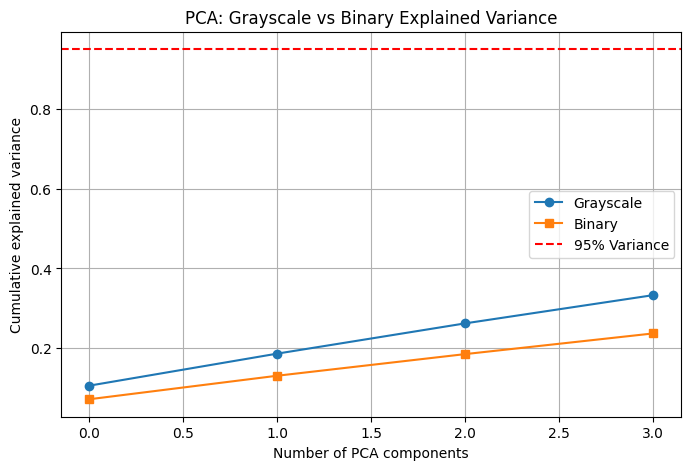

Grayscale PCA shape: (19702, 4)
Binary PCA shape: (19702, 4)
Total variance captured by grayscale: 0.3331145
Total variance captured by binary: 0.23708034


In [6]:
# --------- Plot cumulative explained variance ---------
plt.figure(figsize=(8,5))

# Plot cumulative variance for grayscale and binary PCA
plt.plot(cumulative_variance_gray, marker='o', label='Grayscale')
plt.plot(cumulative_variance_binary, marker='s', label='Binary')

# Add horizontal line at 95% variance for reference
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')

# Label axes and title
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA: Grayscale vs Binary Explained Variance")

# Add grid and legend
plt.grid(True)
plt.legend()
plt.show()

# --------- Print PCA results info ---------
print("Grayscale PCA shape:", X_gray_pca.shape)  # Shape after PCA transformation
print("Binary PCA shape:", X_binary_pca.shape)
print("Total variance captured by grayscale:", cumulative_variance_gray[-1])  # Total explained variance
print("Total variance captured by binary:", cumulative_variance_binary[-1])

In [7]:
# --------- Split data into training and testing sets ---------
# Grayscale PCA data
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    X_gray_pca,               # Features
    y_gray,                   # Labels
    test_size=0.2,            # 20% for testing
    random_state=42,          # For reproducibility
    stratify=y_gray           # Preserve label distribution
)

# Binary PCA data
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary_pca,             # Features
    y_binary,                 # Labels
    test_size=0.2,            # 20% for testing
    random_state=42,          # For reproducibility
    stratify=y_binary         # Preserve label distribution
)

In [8]:
# --------- Convert data to PyTorch tensors ---------
# Grayscale data
X_train_gray_t = torch.tensor(X_train_gray, dtype=torch.float32)  # Features as float tensors
y_train_gray_t = torch.tensor(y_train_gray, dtype=torch.long)     # Labels as long tensors
X_test_gray_t = torch.tensor(X_test_gray, dtype=torch.float32)    # Test features as float tensors
y_test_gray_np = y_test_gray                                       # Keep test labels as numpy for sklearn metrics

# Binary data
X_train_binary_t = torch.tensor(X_train_binary, dtype=torch.float32)  # Features as float tensors
y_train_binary_t = torch.tensor(y_train_binary, dtype=torch.long)     # Labels as long tensors
X_test_binary_t = torch.tensor(X_test_binary, dtype=torch.float32)    # Test features as float tensors
y_test_binary_np = y_test_binary                                       # Keep test labels as numpy for sklearn metrics

In [9]:
import torch
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# --------- Define a basic quantum layer for PyTorch ---------
class BasicQuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        n = 4  # Number of qubits / input features

        # Parameter vectors for encoding input features and variational angles
        self.x_params     = ParameterVector("x", n)
        self.theta_params = ParameterVector("θ", n)

        # Build quantum circuit
        qc = QuantumCircuit(n)
        
        # Angle-encode each feature into a qubit using Ry rotations
        for i in range(n):
            qc.ry(self.x_params[i] * np.pi, i)
        
        # Chain entanglement using CNOT gates
        for i in range(n-1):
            qc.cx(i, i+1)
        
        # Variational layer: one Ry rotation per qubit
        for i in range(n):
            qc.ry(self.theta_params[i], i)

        # Define one Z observable per qubit → 4 outputs
        observables = [
            SparsePauliOp.from_list([("I"*i + "Z" + "I"*(n-i-1), 1.0)])
            for i in range(n)
        ]

        # Wrap the circuit into an EstimatorQNN and connect it to PyTorch
        qnn = EstimatorQNN(
            circuit=qc,
            input_params=list(self.x_params),
            weight_params=list(self.theta_params),
            observables=observables,
            estimator=StatevectorEstimator()
        )
        self.qlayer = TorchConnector(qnn)

    def forward(self, x):
        """
        Forward pass through the quantum layer.
        Input x: [batch_size, 4] → Output: [batch_size, 4]
        """
        return self.qlayer(x)

In [10]:
import torch.nn as nn

# --------- Define hybrid models (quantum + classical) ---------

# Grayscale model
model_gray = nn.Sequential(
    BasicQuantumLayer(),  # Quantum layer: input [batch, 4], output [batch, 4]
    nn.Linear(4, 16),    # Classical fully connected layer
    nn.ReLU(),            # Non-linear activation
    nn.Linear(16, 10)    # Output layer for 10 classes
)

# Binary model
model_binary = nn.Sequential(
    BasicQuantumLayer(),  # Quantum layer
    nn.Linear(4, 16),    # Classical fully connected layer
    nn.ReLU(),            # Activation
    nn.Linear(16, 10)    # Output layer for 10 classes
)

# Print model architectures
print(model_gray)
print(model_binary)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Sequential(
  (0): BasicQuantumLayer(
    (qlayer): TorchConnector()
  )
  (1): Linear(in_features=4, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=10, bias=True)
)
Sequential(
  (0): BasicQuantumLayer(
    (qlayer): TorchConnector()
  )
  (1): Linear(in_features=4, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=10, bias=True)
)


Training Grayscale Model


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:04<00:00,  1.47s/it]


Grayscale — Epoch 1/20 — Avg Loss: 1.6546


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:59<00:00,  1.46s/it]


Grayscale — Epoch 2/20 — Avg Loss: 1.6443


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]


Grayscale — Epoch 3/20 — Avg Loss: 1.6405


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:58<00:00,  1.46s/it]


Grayscale — Epoch 4/20 — Avg Loss: 1.6379


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]


Grayscale — Epoch 5/20 — Avg Loss: 1.6363


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]


Grayscale — Epoch 6/20 — Avg Loss: 1.6347


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:58<00:00,  1.46s/it]


Grayscale — Epoch 7/20 — Avg Loss: 1.6339


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:00<00:00,  1.46s/it]


Grayscale — Epoch 8/20 — Avg Loss: 1.6329


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:58<00:00,  1.46s/it]


Grayscale — Epoch 9/20 — Avg Loss: 1.6314


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:58<00:00,  1.46s/it]


Grayscale — Epoch 10/20 — Avg Loss: 1.6303


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:57<00:00,  1.45s/it]


Grayscale — Epoch 11/20 — Avg Loss: 1.6295


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]


Grayscale — Epoch 12/20 — Avg Loss: 1.6278


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:17<00:00,  1.50s/it]


Grayscale — Epoch 13/20 — Avg Loss: 1.6276


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]


Grayscale — Epoch 14/20 — Avg Loss: 1.6269


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]


Grayscale — Epoch 15/20 — Avg Loss: 1.6261


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:55<00:00,  1.45s/it]


Grayscale — Epoch 16/20 — Avg Loss: 1.6250


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]


Grayscale — Epoch 17/20 — Avg Loss: 1.6234


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:55<00:00,  1.45s/it]


Grayscale — Epoch 18/20 — Avg Loss: 1.6223


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:57<00:00,  1.46s/it]


Grayscale — Epoch 19/20 — Avg Loss: 1.6207


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:56<00:00,  1.45s/it]

Grayscale — Epoch 20/20 — Avg Loss: 1.6197


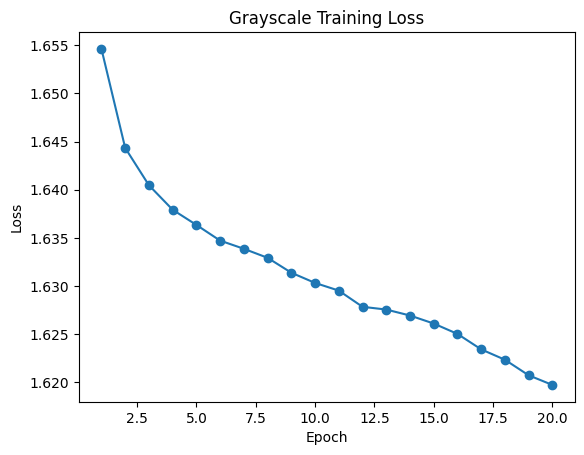

Grayscale Basic QNN hybrid accuracy: 39.79%


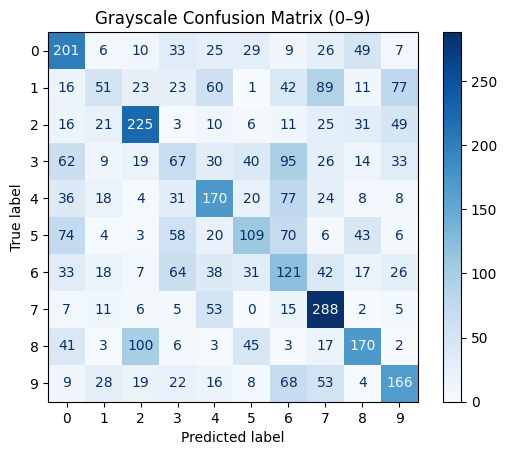

Training Binary Model


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:01<00:00,  1.46s/it]


Binary — Epoch 1/20 — Avg Loss: 2.2260


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:00<00:00,  1.46s/it]


Binary — Epoch 2/20 — Avg Loss: 2.1893


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:00<00:00,  1.46s/it]


Binary — Epoch 3/20 — Avg Loss: 2.1839


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:01<00:00,  1.46s/it]


Binary — Epoch 4/20 — Avg Loss: 2.1800


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:01<00:00,  1.46s/it]


Binary — Epoch 5/20 — Avg Loss: 2.1769


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:00<00:00,  1.46s/it]


Binary — Epoch 6/20 — Avg Loss: 2.1740


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:01<00:00,  1.46s/it]


Binary — Epoch 7/20 — Avg Loss: 2.1718


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [11:59<00:00,  1.46s/it]


Binary — Epoch 8/20 — Avg Loss: 2.1703


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 493/493 [12:01<00:00,  1.46s/it]


Binary — Epoch 9/20 — Avg Loss: 2.1686


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:06<00:00,  1.47s/it]


Binary — Epoch 10/20 — Avg Loss: 2.1679


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:01<00:00,  1.46s/it]


Binary — Epoch 11/20 — Avg Loss: 2.1674


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:00<00:00,  1.46s/it]


Binary — Epoch 12/20 — Avg Loss: 2.1666


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:00<00:00,  1.46s/it]


Binary — Epoch 13/20 — Avg Loss: 2.1669


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:04<00:00,  1.47s/it]


Binary — Epoch 14/20 — Avg Loss: 2.1665


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:04<00:00,  1.47s/it]


Binary — Epoch 15/20 — Avg Loss: 2.1668


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:58<00:00,  1.46s/it]


Binary — Epoch 16/20 — Avg Loss: 2.1664


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:58<00:00,  1.46s/it]


Binary — Epoch 17/20 — Avg Loss: 2.1659


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [11:57<00:00,  1.46s/it]


Binary — Epoch 18/20 — Avg Loss: 2.1664


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:02<00:00,  1.47s/it]


Binary — Epoch 19/20 — Avg Loss: 2.1662


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████| 493/493 [12:03<00:00,  1.47s/it]

Binary — Epoch 20/20 — Avg Loss: 2.1663


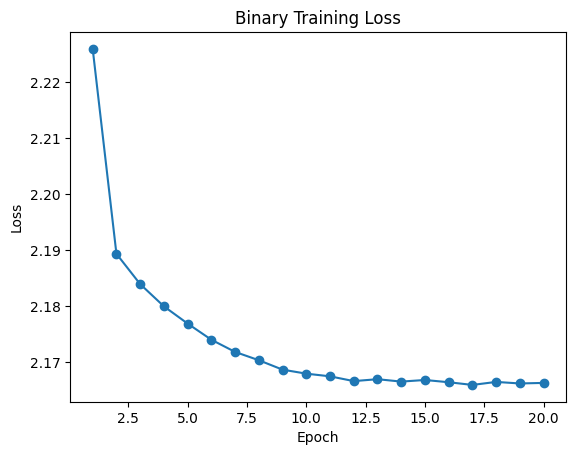

Binary Basic QNN hybrid accuracy: 21.47%


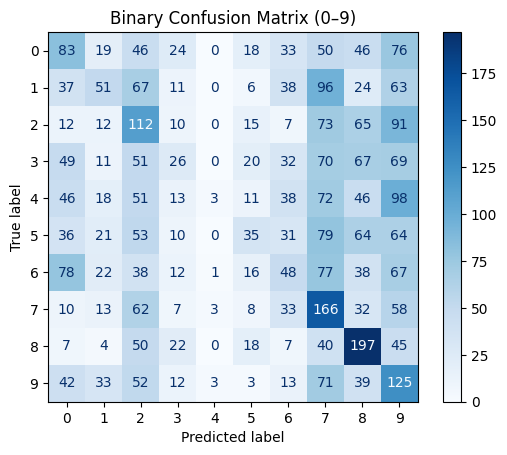

In [12]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# --- Hyperparameters ---
epochs = 20
batch_size = 32
lr = 0.01

# --- Checkpoint paths ---
checkpoint_gray = "checkpoint_gray.pth"
checkpoint_binary = "checkpoint_binary.pth"

# --- Initialize losses ---
losses_gray = []
losses_binary = []

# --- Grayscale Model Setup ---
loss_fn_gray = nn.CrossEntropyLoss()
optimizer_gray = optim.Adam(model_gray.parameters(), lr=lr)
num_samples_gray = X_train_gray_t.shape[0]
start_epoch_gray = 1

# Load checkpoint if exists
if os.path.exists(checkpoint_gray):
    checkpoint = torch.load(checkpoint_gray)
    model_gray.load_state_dict(checkpoint['model_state'])
    optimizer_gray.load_state_dict(checkpoint['optimizer_state'])
    losses_gray = checkpoint['losses']
    start_epoch_gray = checkpoint['epoch'] + 1
    print(f"Resuming Grayscale training from epoch {start_epoch_gray}")

# --- Grayscale Training ---
print("Training Grayscale Model")
for ep in range(start_epoch_gray, epochs + 1):
    model_gray.train()
    epoch_loss = 0
    for i in tqdm(range(0, num_samples_gray, batch_size), desc=f"Epoch {ep}/{epochs}"):
        X_batch = X_train_gray_t[i:i + batch_size]
        y_batch = y_train_gray_t[i:i + batch_size]

        optimizer_gray.zero_grad()
        logits = model_gray(X_batch)
        loss = loss_fn_gray(logits, y_batch)
        loss.backward()
        optimizer_gray.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / (num_samples_gray // batch_size)
    losses_gray.append(avg_loss)
    print(f"Grayscale — Epoch {ep}/{epochs} — Avg Loss: {avg_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': ep,
        'model_state': model_gray.state_dict(),
        'optimizer_state': optimizer_gray.state_dict(),
        'losses': losses_gray
    }, checkpoint_gray)

# Plot Grayscale Loss
plt.plot(range(1, len(losses_gray)+1), losses_gray, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Grayscale Training Loss")
plt.show()

# Grayscale Evaluation
model_gray.eval()
with torch.no_grad():
    preds_gray = model_gray(X_test_gray_t).argmax(dim=1).numpy()

acc_gray = accuracy_score(y_test_gray_np, preds_gray)
print(f"Grayscale Basic QNN hybrid accuracy: {acc_gray*100:.2f}%")

cm_gray = confusion_matrix(y_test_gray_np, preds_gray)
disp_gray = ConfusionMatrixDisplay(cm_gray, display_labels=list(range(10)))
disp_gray.plot(cmap=plt.cm.Blues)
plt.title("Grayscale Confusion Matrix (0–9)")
plt.show()


# --- Binary Model Setup ---
loss_fn_binary = nn.CrossEntropyLoss()
optimizer_binary = optim.Adam(model_binary.parameters(), lr=lr)
num_samples_binary = X_train_binary_t.shape[0]
start_epoch_binary = 1

# Load checkpoint if exists
if os.path.exists(checkpoint_binary):
    checkpoint = torch.load(checkpoint_binary)
    model_binary.load_state_dict(checkpoint['model_state'])
    optimizer_binary.load_state_dict(checkpoint['optimizer_state'])
    losses_binary = checkpoint['losses']
    start_epoch_binary = checkpoint['epoch'] + 1
    print(f"Resuming Binary training from epoch {start_epoch_binary}")

# --- Binary Training ---
print("Training Binary Model")
for ep in range(start_epoch_binary, epochs + 1):
    model_binary.train()
    epoch_loss = 0
    for i in tqdm(range(0, num_samples_binary, batch_size), desc=f"Epoch {ep}/{epochs}"):
        X_batch = X_train_binary_t[i:i + batch_size]
        y_batch = y_train_binary_t[i:i + batch_size]

        optimizer_binary.zero_grad()
        logits = model_binary(X_batch)
        loss = loss_fn_binary(logits, y_batch)
        loss.backward()
        optimizer_binary.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / (num_samples_binary // batch_size)
    losses_binary.append(avg_loss)
    print(f"Binary — Epoch {ep}/{epochs} — Avg Loss: {avg_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': ep,
        'model_state': model_binary.state_dict(),
        'optimizer_state': optimizer_binary.state_dict(),
        'losses': losses_binary
    }, checkpoint_binary)

# Plot Binary Loss
plt.plot(range(1, len(losses_binary)+1), losses_binary, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Binary Training Loss")
plt.show()

# Binary Evaluation
model_binary.eval()
with torch.no_grad():
    preds_binary = model_binary(X_test_binary_t).argmax(dim=1).numpy()

acc_binary = accuracy_score(y_test_binary_np, preds_binary)
print(f"Binary Basic QNN hybrid accuracy: {acc_binary*100:.2f}%")

cm_binary = confusion_matrix(y_test_binary_np, preds_binary)
disp_binary = ConfusionMatrixDisplay(cm_binary, display_labels=list(range(10)))
disp_binary.plot(cmap=plt.cm.Blues)
plt.title("Binary Confusion Matrix (0–9)")
plt.show()
